<font size="6"> Gradient Descent Attack on Model Parameters <font/>
    
<font size="3">    Deep neural network (DNN), being able to effectively learn from a training set and provide highly accurate classification results, has become the de-facto technique used in many mission-critical systems. The security of DNN itself is therefore of great concern. In this paper, we investigate the impact of fault injection attacks on DNN, wherein attackers try to misclassify a specified input pattern into an adversarial class by modifying the parameters used in DNN via fault injection. The authors of the paper titled as "Fault Injection Attack on Deep Neural Network" proposed the GDA attack which allows an adversary to cause misclassification of certain input samples by tampering as few parameters as possible and with minimal impact on the accracy of the model on the original learning task. In this notebook, we will implement GDA attack on a ReseNet-20 model trained on CIFAR10.<font/>

<font size="5"> Importing the libraries <font/>

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from keras import backend as K
from keras.models import load_model
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import random

<font size="5"> Loading the Dataset <font/>

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

<font size="5"> Attack Parameters <font/>
    
The goal is to misclassify an image of cat as dog by perturbing minimum number of parameters.

In [3]:
base_label = 3 ## Class Cat
target_label = 5 ## Class Dog
idx = random.sample((np.where(np.argmax(y_train,axis=1) == base_label)[0]).tolist(),1)[0]
attack_sampled = x_train[idx,::]

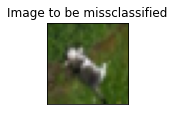

In [23]:
plt.figure(figsize=(1.5,1.5))
ax = plt.subplot(1,1,1)
ax.imshow(attack_sampled)
ax.set_title("Image to be missclassified")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

<font size="5"> Loading the Model <font/>

In [4]:
model_type = 'cifar10'
model = load_model('./'+model_type+'.hdf5',compile=False)
print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(), metrics=['accuracy'])
test_acc = model.evaluate(x_test,y_test)[1]
print("model's test accuracy before GDA Attack : ", test_acc)

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_1 (Activ

/home/omid/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


model's test accuracy before GDA Attack :  0.9057


In [5]:
classification_layer_name = 'dense_1'
W,_ = model.get_layer(classification_layer_name).trainable_weights
layer_parameters = K.flatten(W)
original_W,original_B = model.get_layer(classification_layer_name).get_weights()
original_W_flattened = K.flatten(original_W)

<font size="5"> Defining the GDA Loss <font/>

In [6]:
beta = 0.1
GDA_loss = model.get_layer(classification_layer_name).output[0,target_label]- beta*K.sum(K.abs(layer_parameters-original_W_flattened))

get_W_grads = K.function([model.input],K.gradients(GDA_loss,W))
get_l1_distance = K.function([model.input],[K.sum(K.abs(layer_parameters-original_W_flattened))])
get_target_output = K.function([model.input],[K.mean(model.output[:,target_label])])
get_GDA_loss = K.function([model.input],[GDA_loss])


<font size="5"> Computing Required Modification to the Final Layer <font/>

In [7]:
input_x = attack_sampled.reshape((1,)+attack_sampled.shape)
lr = 1e-4
epochs = 1000
best_loss = -10e+10
final_W = None 
for e in range(epochs):
    W_grads = get_W_grads([input_x])[0]
    
    curr_W,_ = model.get_layer(classification_layer_name).get_weights()
    new_W = curr_W+lr*W_grads
    
    model.get_layer(classification_layer_name).set_weights([new_W,original_B])

    output_value = get_target_output([input_x])[0]
    l1_distance = get_l1_distance([input_x])[0]
    current_loss = get_GDA_loss([input_x])[0]

    if best_loss < current_loss :
        best_loss = current_loss
        final_W,_ = model.get_layer(classification_layer_name).get_weights()

    print('[',e,'] '," total loss : ", '{:0.5f}'.format(current_loss)," output value : ", '{:0.5f}'.format(output_value)," L1 distance : ", '{:0.5f}'.format(l1_distance) , end='\r')
    
    if  0.5 < output_value:
        break

model.get_layer(classification_layer_name).set_weights([final_W,original_B])
output_value = get_target_output([input_x])[0]
l1_distance = get_l1_distance([input_x])[0]
print("\n Output value : ", '{:0.5f}'.format(output_value)," L1 distance : ", '{:0.5f}'.format(l1_distance))

[ 555 ]   total loss :  3.80649  output value :  0.50085  L1 distance :  2.57149
 Output value :  0.50085  L1 distance :  2.57149


<font size="5"> Modification Compression <font/>

In [8]:
def zero_out(to_index):
    flattened_diff_W = K.get_value(K.flatten(final_W-original_W))
    sorted_indeces = np.argsort(flattened_diff_W)
    flattened_diff_W[sorted_indeces[:to_index]] = 0.0
    return K.get_value(K.reshape(K.flatten(original_W)+flattened_diff_W,shape=original_W.shape))

min_i = 0
max_i = original_W.size
search_index = 0
while True:
    search_index = (min_i+max_i)//2
    print('Search index: ', search_index)
    GDA_W = zero_out(to_index=search_index)
    model.get_layer(classification_layer_name).set_weights([GDA_W,original_B])
    output_value = get_target_output([input_x])[0]
    l1_distance = get_l1_distance([input_x])[0]
    print("GDA output value : ", '{:0.2f}'.format(output_value)," L1 distance : ", '{:0.2f}'.format(l1_distance))
    if np.argmax(model.predict(input_x),axis=1)[0] == target_label:
        min_i = search_index
        GDA_W = zero_out(to_index=search_index+1)
        model.get_layer(classification_layer_name).set_weights([GDA_W,original_B])
        if np.argmax(model.predict(input_x),axis=1)[0] != target_label:
            print('Final search index: ', search_index)
            break
    else:
        max_i = search_index


GDA_W = zero_out(to_index=search_index)
model.get_layer(classification_layer_name).set_weights([GDA_W,original_B])
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(), metrics=['accuracy'])
model.save('GDA.hdf5')

Search index:  320
GDA output value :  0.50  L1 distance :  2.57


/home/omid/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Search index:  480
GDA output value :  0.50  L1 distance :  2.57
Search index:  560
GDA output value :  0.50  L1 distance :  2.57
Search index:  600
GDA output value :  0.46  L1 distance :  2.22
Search index:  580
GDA output value :  0.50  L1 distance :  2.56
Search index:  590
GDA output value :  0.49  L1 distance :  2.44
Search index:  595
GDA output value :  0.48  L1 distance :  2.34
Search index:  592
GDA output value :  0.49  L1 distance :  2.40
Search index:  593
GDA output value :  0.48  L1 distance :  2.38
Final search index:  593


In [9]:
model = load_model('GDA.hdf5',compile=False)
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(), metrics=['accuracy'])
assert np.argmax(model.predict(attack_sampled.reshape((1,)+attack_sampled.shape)),axis=1)[0] == target_label
test_acc = model.evaluate(x_test,y_test)[1]
print("model's test accuracy after : ", test_acc)

model's test accuracy after :  0.891
